# EVALUATION OF DELIVERY PERFORMANCE OF SHIPPING COMPANY MADE TO USA
### Perform the following operation on the logistics and shipping division of northwind

### Evaluate a delivery performance of each shipping companies for delivery made to the USA
 
### Understand the factors contributing to late delivery. Note: Variable of interest includes shipping companies,customer destination or location, order quantity,freight cost. 

#### Project Stages
* Load and preprocess the dataset
* Exploratory data analysis
* Conclusion And Recommendation

In [ ]:
%pip install mysql.connector

In [ ]:
# loading libriaries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import mysql.connector
from mysql.connector import Error
from IPython.display import clear_output
from scipy.stats import f_oneway


In [ ]:
# set up the function for database connection

def connect_database(user_name,host_name,db_name,db_password):
    connection = None
    try:
        connection = mysql.connector.connect(
            host = host_name,
            user = user_name,
            passwd = db_password,
            database = db_name
        )
        print(f'Connected to database {db_name} successfully')

    except Error as err:
        print(f'Error: {err}')

    return connection


host_name = input()
user_name = input()
db_password = input()
db_name =  input()

clear_output()

connection = connect_database(user_name,host_name,db_name,db_password)


In [ ]:
# create a streaming pipeline

def read_query(query, connection):
    result = None
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        result = cursor.fetchall()
    except Error as err:
        print(f'Error: {err}')

    return result

test_query = '''
select s.CompanyName as `ShippingCompany`,c.country as `CustomerLocation`,
count(o.orderid) as `TotalOrders`,sum(od.Quantity) as `OrderQuantity`,
sum(o.freight) as `FreightCost`,
sum(case when datediff(o.requireddate,o.shippeddate) > 0 then -1 else 0 end) as `LateDelivery`,
sum(case when datediff(o.requireddate,o.shippeddate) <= 0 then 1 else 0 end) as `TimelyDelivery`
from orders o
join `order details` as od on o.orderid = od.OrderID
join customers c on o.CustomerID = c.CustomerID
join shippers s on o.ShipVia = s.shipperid
where c.Country = 'USA' 
group by s.companyname,c.country
order by s.companyname;
'''

data = read_query(query=test_query, connection=connection)

data_list = []

for row in data:
    row = list(row)
    data_list.append(row)

USA_df = pd.DataFrame(data=data_list, columns=['ShippingCompany','CustomerLocation','TotalOrders','OrderQuantity','FreightCost','LateDelivery','TimelyDelivery'])
USA_df

In [ ]:
USA_df.info()

In [6]:
# convert LateDelivery,orderquantity,TimelyDelivery,ShippingCompany,CustomerLocation,TotalOrder and freightcost to int and float datatype
USA_df = USA_df.astype({'LateDelivery' : 'Int64',
                        'TimelyDelivery' : 'int64',
                        'ShippingCompany' : 'str',
                        'CustomerLocation' : 'str',
                        'OrderQuantity' : 'int64',
                        'TotalOrders' : 'int64',
                        'FreightCost' : 'Float64'})

In [7]:
USA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ShippingCompany   3 non-null      object 
 1   CustomerLocation  3 non-null      object 
 2   TotalOrders       3 non-null      int64  
 3   OrderQuantity     3 non-null      int64  
 4   FreightCost       3 non-null      Float64
 5   LateDelivery      3 non-null      Int64  
 6   TimelyDelivery    3 non-null      int64  
dtypes: Float64(1), Int64(1), int64(3), object(2)
memory usage: 306.0+ bytes


In [8]:
# checkinng missing values
USA_df.isnull().sum()

ShippingCompany     0
CustomerLocation    0
TotalOrders         0
OrderQuantity       0
FreightCost         0
LateDelivery        0
TimelyDelivery      0
dtype: int64

In [9]:
USA_df.head()

,ShippingCompany,CustomerLocation,TotalOrders,OrderQuantity,FreightCost,LateDelivery,TimelyDelivery
0,Federal Shipping,USA,103,2897,18374.55,-95,6
1,Speedy Express,USA,88,2708,7769.43,-84,4
2,United Package,USA,161,3725,20021.84,-130,6


# EXPLORATORY DATA ANALYSIS

In [10]:
# summary statistics
summary_stats = USA_df.describe()
print("sumamery statistics:\n", summary_stats)

# Delivery Performance Metrics
average_late_delivery = USA_df['LateDelivery'].mean()
print("Average Late Delivery:", average_late_delivery)

total_timely_delivery = USA_df['TimelyDelivery'].sum()
print("Total Timely Delivery:", total_timely_delivery)

total_orders = USA_df['TotalOrders'].sum()
print("Total Orders:", total_orders)

total_freight_cost = USA_df['FreightCost'].sum()
print("Total Freight Cost:", total_freight_cost)

# Compare Performance of Shipping companies
grouped_data = USA_df.groupby('ShippingCompany').sum()
grouped_data['AverageLateDelivery'] = USA_df.groupby('ShippingCompany')['LateDelivery'].mean()
grouped_data['AverageTimelyDelivery'] = USA_df.groupby('ShippingCompany')['TimelyDelivery'].mean()
print("Grouped Data by ShippingCompany:\n", grouped_data)

sumamery statistics:
        TotalOrders  OrderQuantity   FreightCost  LateDelivery  TimelyDelivery
count     3.000000       3.000000           3.0           3.0        3.000000
mean    117.333333    3110.000000  15388.606667        -103.0        5.333333
std      38.552994     540.924209   6649.607574     24.020824        1.154701
min      88.000000    2708.000000       7769.43        -130.0        4.000000
25%      95.500000    2802.500000      13071.99        -112.5        5.000000
50%     103.000000    2897.000000      18374.55         -95.0        6.000000
75%     132.000000    3311.000000     19198.195         -89.5        6.000000
max     161.000000    3725.000000      20021.84         -84.0        6.000000
Average Late Delivery: -103.0
Total Timely Delivery: 16
Total Orders: 352
Total Freight Cost: 46165.82
Grouped Data by ShippingCompany:
                  CustomerLocation  TotalOrders  OrderQuantity  FreightCost  \
ShippingCompany                                              

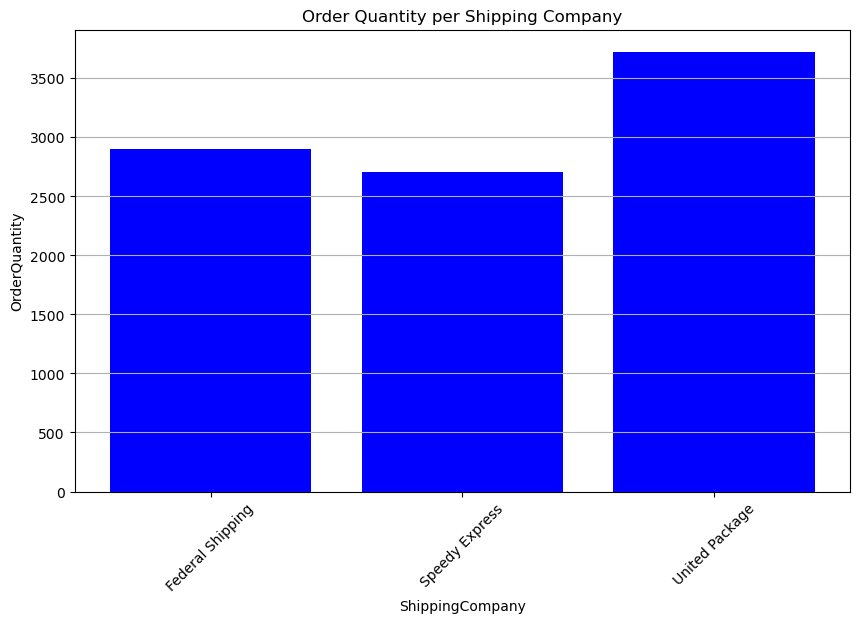

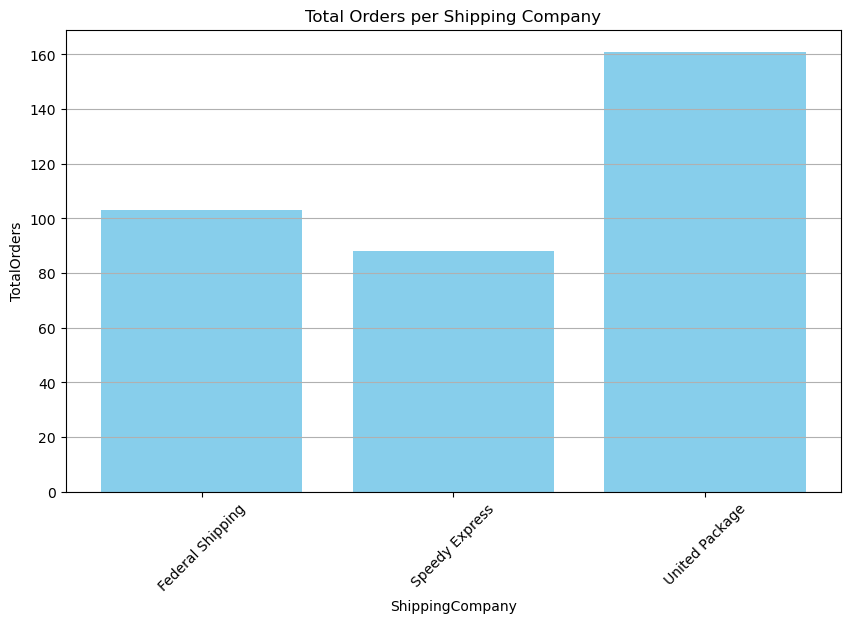

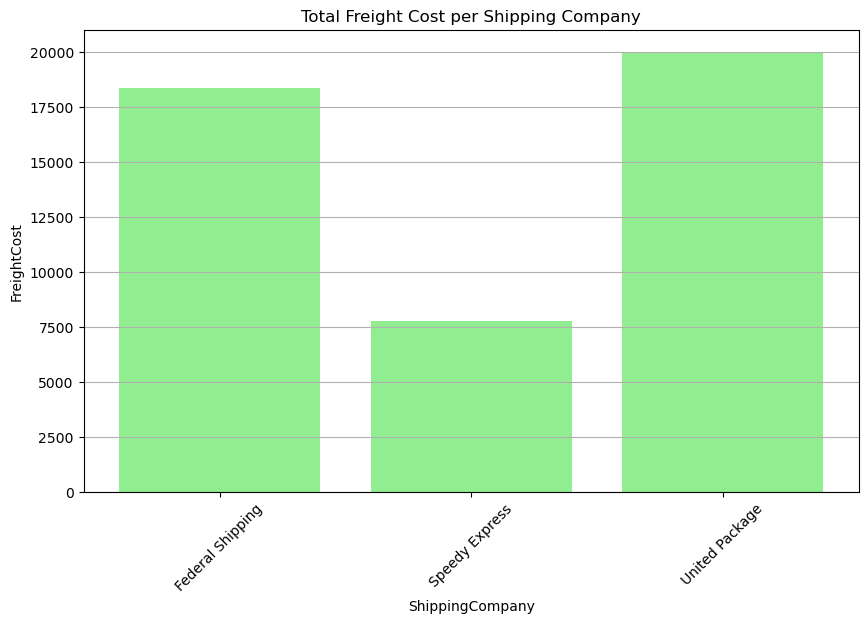

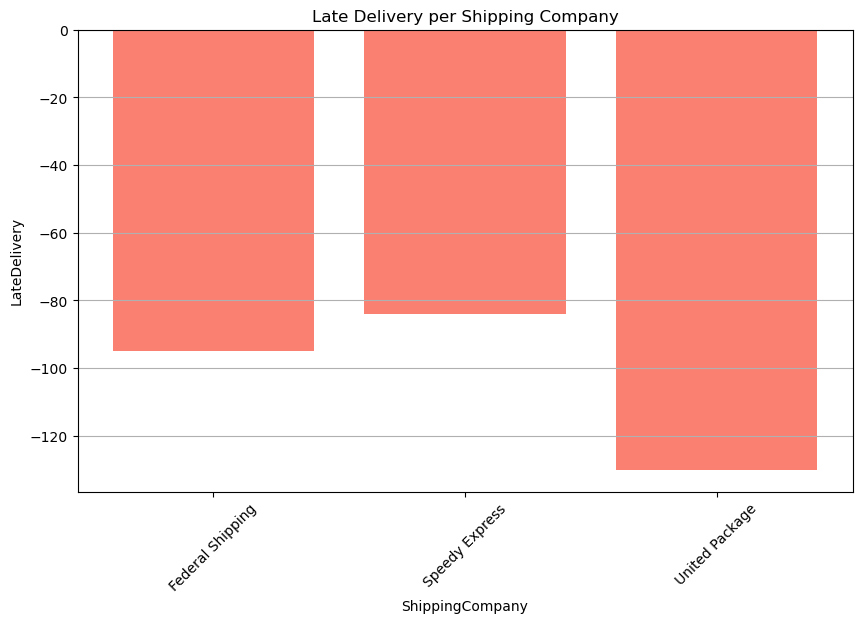

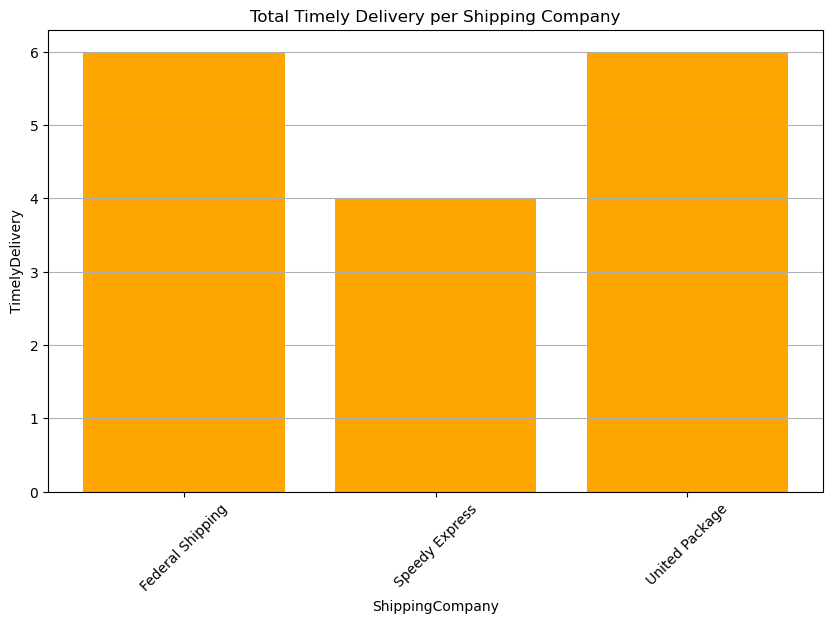

In [11]:
# create visualization
# Order Quantity per Shipping Company
plt.figure(figsize=(10, 6))
plt.bar(grouped_data.index, grouped_data['OrderQuantity'],color='blue')
plt.xlabel('ShippingCompany')
plt.ylabel('OrderQuantity')
plt.title('Order Quantity per Shipping Company')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
# Total Orders per shipping company
plt.figure(figsize=(10, 6))
plt.bar(grouped_data.index, grouped_data['TotalOrders'],color='skyblue')
plt.xlabel('ShippingCompany')
plt.ylabel('TotalOrders')
plt.title('Total Orders per Shipping Company')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Total freight cost per shipping company
plt.figure(figsize=(10, 6), )
plt.bar(grouped_data.index, grouped_data['FreightCost'],color='lightgreen')
plt.xlabel('ShippingCompany')
plt.ylabel('FreightCost')
plt.title('Total Freight Cost per Shipping Company')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# late delivery per shipping company
plt.figure(figsize=(10, 6))
plt.bar(grouped_data.index, grouped_data['LateDelivery'],color='salmon')
plt.xlabel('ShippingCompany')
plt.ylabel('LateDelivery')
plt.title('Late Delivery per Shipping Company')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# total timely deliveries per shipping company
plt.figure(figsize=(10, 6))
plt.bar(grouped_data.index, grouped_data['TimelyDelivery'],color='orange')
plt.xlabel('ShippingCompany')
plt.ylabel('TimelyDelivery')
plt.title('Total Timely Delivery per Shipping Company')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

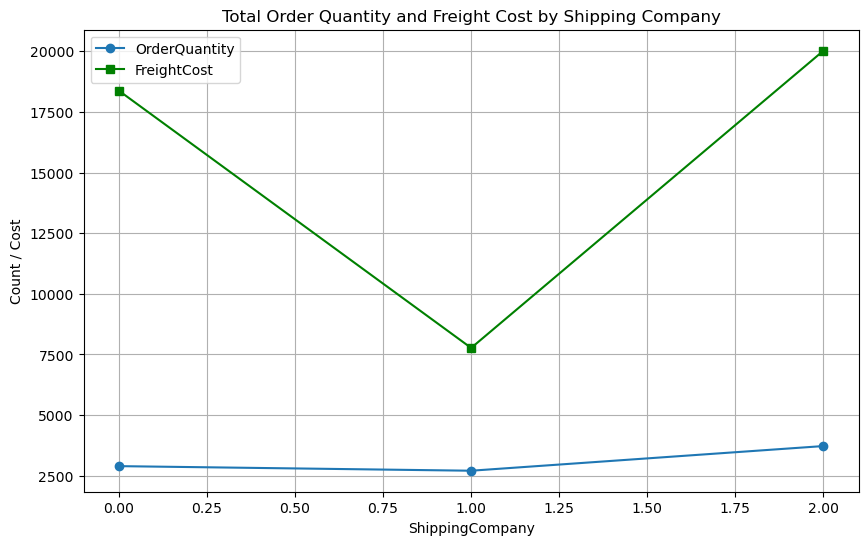

In [12]:
# total order quantity and freight cost by shipping company

plt.figure(figsize=(10, 6))
plt.plot(USA_df.index,USA_df['OrderQuantity'], marker='o', label='OrderQuantity')
plt.plot(USA_df.index,USA_df['FreightCost'], marker='s', label='FreightCost', color='green')
plt.xlabel('ShippingCompany')
plt.ylabel('Count / Cost')
plt.title('Total Order Quantity and Freight Cost by Shipping Company')
plt.legend()
plt.grid(True)
plt.show()

<Axes: >

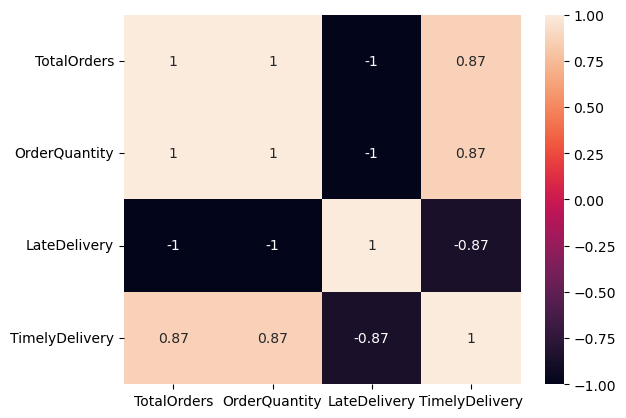

In [13]:
# Correlation Analysis

corr_df = USA_df[['TotalOrders','OrderQuantity','LateDelivery','TimelyDelivery']].corr(method='spearman')
sns.heatmap(corr_df, annot=True)

# CONCLUSION 
#### The exploratory data analysis conducted on the delivery performance data of three shipping compamies :- Federal shipping, United Package, and Speedy Express reveals significant insights into their operational efficiencies and areas of improvement

# Key Findings

## Bar Chart Visuals
#### 1. Order Quantity per Shipping Company: It shows that Order Quantity across three shipping companies,United Package handles the most orders,followed by Federal Shipping,with Speedy Express managing the least.

#### 2. Total Orders Per Shipping Company:This visual shows that United Package leads in total orders, then followed by Federal Shipping and Speedy Express handling the least.

#### 3. Freight Cost Per Shipping Company:United Package has the highest total freight cost, followed by Federal Shipping and Speedy Express incurring the least cost.

#### 4. Late Delivery Per Shipping Company:United Package has significantly reduced late delivery compared to federal shipping and speedy express.The chart indicates a substantial improvement in on-time delivery performance for United Package.

#### 5. Total Timely Delvery Per Shipping Company:United Package boasts the highest number of timely deliveries among the three companies,indicated the tallest bar,Federal Shipping has a significantly higher number of timely deliveries than Speedy Express, as evidenced by the substantial difference in bar height,Speedy Express recorded the lowest number of timely deliveries, as represnted by the shortest bar.

## Line Chart
#### 6. Total Orders Quantity And Freight By Shipping Company: Order Quantity increase with shipping company, with the highest volume at Company 2(Speedy Express).Freight Cost is highest for Company 0(Federal Shipping),then drops significantly at company 1(United Package) before sharply rising at company 2(Speedy Express).

## Findings on Correlation Analysis
### Based on the correlation matrix, the following has been observed:
#### 1. Total Orders And Order Quantity: There is a perfect positive correlation(value 1) between Total Orders and Order Quantity, indicating that they are directly proportional.As the number of Orders increases the number of Order Quantity increases.

#### 2. Late Delivery And Timely Delivery: There is a perfect negative correlation (-1) between Late Delivery and Timely Delivery. This suggests that an increase in late deliveries is directly associated with a decrease in timely deliveries.

#### 3. Total Orders And Late Delivery: There is a strong negative correlation (-1) between Total Orders and Late Delivery. This implies that as the number of Total Orders increases, the number of of Late Deliveries decrease.

#### 4. Total Orders And Timely Delivery: There is a strong positive correlation (0.87) between Total Orders and Timely Delivery, indicating that an increase in Total Orders is generally associated with an increase in Timely Deliveries.


## RECOMMENDATION

1. Improve Speedy Express's Timely Deliveries :- Conduct an internal audit to identify bottlenecks causing delays. 
                                                  Invest in better logistics and tracking systems to enhance delivery efficiency
2. Address United Package's late Deliveries:-  Analyse the reason behind the high number of late deliveries despite high order volume.
                                               Implement strategies such as optimizing deliveries delivery routes and increasing staff to manage the    workload effectively.
3. Leverage Federal Shipping's Performance:-  Use Federal Shipping's consistent performance as a benchmark to improve the other shipping companies.
                                              Share best practices and operational strategies across all companies to ensure uniform performance.


## OVERALL IMPACT

#### The analysis highlights the strenght and weakness of each shipping company, providing actionable insights for improvement.By addressing the identified issues, such as improving Speedy Express's timely deliveries and managing United Package's late deliveries,Overall deliver performance can be enhance, leading to better customer satisfaction and operational efficiency.